# Predicting house prices with neural networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data

### loading the data

In [2]:
raw_data = pd.read_csv("https://raw.githubusercontent.com/michalis0/BigScaleAnalytics/master/week11/data/train.csv")
raw_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
raw_data.shape

(1460, 81)

### Extracting the numeric columns

In [4]:
raw_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [5]:
numeric_columns = list(raw_data.columns[(raw_data.dtypes==np.int64) |
                 (raw_data.dtypes==np.float64)])
print(numeric_columns, "\n", len(numeric_columns))

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 
 38


Set `SalesPrice` as the last index, since it is the value we want to predict.

In [6]:
numeric_columns.remove('SalePrice')
numeric_columns.append('SalePrice')

We do not need the `Id` column.

In [7]:
numeric_columns.remove('Id')

Now we extract the numeric data.

In [8]:
numeric_data = raw_data[numeric_columns]
numeric_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


Now let's deal with the missing values in the data.

In [9]:
nan_columns = np.any(pd.isna(numeric_data), axis = 0)
nan_columns = list(nan_columns[nan_columns == True].index)
nan_columns

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

We simply replace them with zero.

In [10]:
numeric_data['LotFrontage'] = numeric_data['LotFrontage'].fillna(0)
numeric_data['MasVnrArea'] = numeric_data['MasVnrArea'].fillna(0)
numeric_data['GarageYrBlt'] = numeric_data['GarageYrBlt'].fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

let's split the data for training and test!

In [11]:
from sklearn.model_selection import train_test_split
numeric_data_train, numeric_data_test = train_test_split(numeric_data, test_size=0.1)

### Normalizing the data
Before training our linear regression model, we have to normalize the data. We do this by subtracting each column from its minimum value and then dividing it by the difference between maximum and minimum.

In [12]:
# saving max, min for each column
maxs, mins = dict(), dict()

In [13]:
for col in numeric_data:
    maxs[col] = numeric_data_train[col].max()
    mins[col] = numeric_data_train[col].min()

In [14]:
numeric_data_train = (numeric_data_train - numeric_data_train.min()) / (numeric_data_train.max() - numeric_data_train.min())

## Building a Linear Regression model

In [15]:
import torch
import torch.nn as nn

In [16]:
numeric_x_columns = list(numeric_data_train.columns)
numeric_x_columns.remove("SalePrice")
X_train_df = numeric_data_train[numeric_x_columns]
y_train_df = pd.DataFrame(numeric_data_train["SalePrice"])

Now we have to convert the data into torch tensors. A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type. It's very similar to arrays in `NumPy`.

In [17]:
X_train = torch.tensor(X_train_df.values, dtype=torch.float)
y_train = torch.tensor(y_train_df.values, dtype=torch.float)

In [18]:
print(X_train.size(), y_train.size())

torch.Size([1314, 36]) torch.Size([1314, 1])


### Defining a model with pytorch
A model is always defined as a class in pytorch. It should have a `__init__` function in which you define the layers of your network. It also should have a `forward` function (method) that basically defines the forward pass on the network.

For the beggining, let's start with a single layer network.

In [19]:
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        y_pred = self.activation(self.linear1(x))
        y_pred = self.linear2(y_pred)
        return y_pred

In [20]:
D_in, D_out = X_train.shape[1], y_train.shape[1]

In [21]:
# defining the first model: an instance of the class "Net"
model1 = Net(D_in, 500, D_out)

The next steps is to define the __loss criterion__ and the __optimizer__ for the network. That is, we have to define the loss function we want to optimize during training and also the optimization method we are going to use, e.g, SGD, etc.

In [22]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-4)

Now, we are ready to do the training. We can simply do this by a for loop over the number of iterations. The training has 3 main steps:
- A forward pass to compute the prediction for the current data point (batch).
- computing the loss for the current prediction.
- A backward pass to compute the gradient of the loss with respect to the weight of the network.
- Finaly, updating the weights of the network (`optimizer.step()`).

Note that in each backward pass pytorch saves the gradient for all of the parameters. Therefore it is important to replace the old gradient values with zero in the beggining of each iteration, otherwise the gradients will be accumulated during the iterations!

In [23]:
losses1 = []

for t in range(500):
    y_pred = model1(X_train)
    
    loss = criterion(y_pred, y_train)
    print(t, loss.item())
    losses1.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 146.5303955078125
1 1363.1669921875
2 11021.28515625
3 5159.28369140625
4 43.230140686035156
5 32.782310485839844
6 27.2390193939209
7 24.230106353759766
8 22.531064987182617
9 21.50863265991211
10 20.83716583251953
11 20.348913192749023
12 19.95720100402832
13 19.616718292236328
14 19.30510139465332
15 19.01072883605957
16 18.727643966674805
17 18.4523868560791
18 18.182209014892578
19 17.916404724121094
20 17.654808044433594
21 17.397430419921875
22 17.143587112426758
23 16.892662048339844
24 16.645299911499023
25 16.400793075561523
26 16.1595516204834
27 15.920892715454102
28 15.684690475463867
29 15.450624465942383
30 15.218213081359863
31 14.98702621459961
32 14.757043838500977
33 14.528696060180664
34 14.301889419555664
35 14.076449394226074
36 13.852360725402832
37 13.629881858825684
38 13.409223556518555
39 13.19043254852295
40 12.973780632019043
41 12.75988483428955
42 12.547818183898926
43 12.336686134338379
44 12.126058578491211
45 11.916820526123047
46 11.709786415100098


Now let's try a new model with more neurons in the hidden layer.

In [24]:
model2 = Net(D_in, 1000, D_out)

In [25]:
# MSE loss
criterion = nn.MSELoss(reduction='sum')
# SGD optimizer for finding the weights of the network
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-4)

In [26]:
losses2 = []

for t in range(500):
    y_pred = model2(X_train)
    
    loss = criterion(y_pred, y_train)
    # print(t, loss.item())
    losses2.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

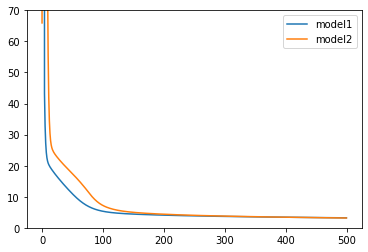

In [27]:
plt.plot(losses1, label="model1")
plt.plot(losses2, label="model2")
plt.ylim([0, 70])
plt.legend()

Let's compare the MSE loss on the test data

In [28]:
# we need to normalize the test data with the min and max value
# from the training data
for col in numeric_data_test.columns:
    numeric_data_test[col] = (numeric_data_test[col] - mins[col]) / (maxs[col] - mins[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
y_test_df = pd.DataFrame(numeric_data_test["SalePrice"])
y_test = torch.tensor(y_test_df.values, dtype=torch.float)
x_test_df = numeric_data_test[numeric_x_columns]
x_test = torch.tensor(x_test_df.values, dtype=torch.float)
# prediction for model 1
model1_pred = model1(x_test)
print("MSE loss for model1: ", criterion(model1_pred, y_test))
# prediction for model 2
model2_pred = model2(x_test)
print("MSE loss for model2: ", criterion(model2_pred, y_test))


MSE loss for model1:  tensor(0.2860, grad_fn=<MseLossBackward>)
MSE loss for model2:  tensor(0.2904, grad_fn=<MseLossBackward>)


## Now it is your turn!
### Exercises

1- Let's get back to model1. This time try to train it with a new optimizer. Try the Adam optimizer (which has shown to be faster than SGD for non-convex functions) and compare the trainig loss curve with SGD. Plot the training loss for the model trained with SGD and Adam optimizer.

Note1: Use `torch.optim.Adam(model1.parameters(), lr=...)`

Note2: If you are interested, check [this nice post](https://ruder.io/optimizing-gradient-descent/index.html) on differen gradient descent optimization algorithms.

2- This time we want to build a new model with a new architecture. Specifically, we want to train a network with 3 hidden layers on the data. You can use the following code to build the architecture. Use the values 500, 1000, 200 for H1, H2, and H3 respectively. Train this new network on the same training data and compare it with the model1 we built above.

```
class Net_new(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net_new, self).__init__()

        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        self.activation = nn.ReLU()

    def forward(self, x):
        y_pred = self.activation(self.linear1(x))
        y_pred = self.activation(self.linear2(y_pred))
        y_pred = self.activation(self.linear3(y_pred))
        y_pred = self.linear4(y_pred)
        return y_pred
```